In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Please change this into either A or B to switch between the two tasks
TASK_NUMBER = 'A'

# Libraries and Variables

* Reading `config.yaml` which contains all ML parameters as well as filepaths
* Import all dependencies and libraries







In [0]:
# load configuration file that store all the constant and parameters settings
import yaml
CONFIG_YAML_FILEPATH = '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/config.yaml'
with open(CONFIG_YAML_FILEPATH, 'r') as file:
  cfg = yaml.safe_load(file)

In [0]:
if TASK_NUMBER == 'A':
  train_csv_filepath = cfg['paths']['cleaned_train_a']
  test_csv_filepath = cfg['paths']['cleaned_test_a']
  saved_model_filepath = cfg['paths']['task_a_model']
elif TASK_NUMBER == 'B':
  train_csv_filepath = cfg['paths']['cleaned_train_b']
  test_csv_filepath = cfg['paths']['cleaned_test_b']
  saved_model_filepath = cfg['paths']['task_b_model']

In [0]:
# install additional dependencies
! pip install -r {cfg['paths']['requirements']}

import pandas as pd
import os
import torch
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import csv
import numpy as np
# import tensorboard as tb
# import tensorflow as tf


# # load the TensorBoard notebook extension
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# %load_ext tensorboard

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 184kB 14.8MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp36-none-any.whl size=82843 sha256=bd68edaa8299a74def816af77ff5af95a75b1dd2df92907f37b1f1fcbd6252ab
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ftfy: filename=ftfy-5.7-cp36-none-any.whl size=44593 sha256=9fd8c31a542a920828ede39bb7f10215e9104f0a7398e504c25d6db20c67d51b
  Stored in directory: /root/.cache/pip/wheels/8e/da/59/6c8925d571aacade638a0f515960c21c0887af1bfe31908fbf
Successfully built ekphrasis ftfy


# Load Dataset and Data Preprocessing

## Preprocess Additional Dataset
In task A, there are some additional datasets (sms and livejournal datasets) that were given from the competition apart from the standard twitter corpus. We can use both of these additional datasets, after we preprocess the formatting so that it matches the rest of the twitter datasets.

In [0]:
task_a_train_additional_dfs = {}

for filename in cfg['paths']['train_additional_dataset_filenames']:
  # read additional corpora
  task_a_train_additional_dfs[filename] = pd.read_csv(os.path.join(cfg['paths']['train_folder_task_a'], filename), sep='\t', header=None, quoting=csv.QUOTE_NONE)
  
  if filename == 'livejournal-2014test-A.tsv':
    # remove the 0-th column from livejournal corpora, as it is unnecessary
    task_a_train_additional_dfs[filename] = task_a_train_additional_dfs[filename].drop(columns=[0])
  elif filename == 'sms-2013test-A.tsv':
    # remove the 1st column from sms corpora, as it is unnecessary
    task_a_train_additional_dfs[filename] = task_a_train_additional_dfs[filename].drop(columns=[1])
  
  # reset the column index to make it incremental
  task_a_train_additional_dfs[filename].columns = range(task_a_train_additional_dfs[filename].shape[1])
  
  print(task_a_train_additional_dfs[filename])

             0         1                                                  2
0     LJ111111  negative  I know I missed something here , but what does...
1     LJ111113   neutral  What do you think of Beside Ourselves as a tit...
2     LJ111114  positive                    :D I intend to be one someday .
3     LJ111117  negative  LLLINKKK LLLINKKK IIIMAGEEELLLINKKK The choice...
4     LJ111119   neutral                     LLLINKKK Some more mountains .
...        ...       ...                                                ...
1137  LJ113616  positive                     Maybe it was - his - fantasy ?
1138  LJ113618  negative  It was ok , but they always just seem so nervo...
1139  LJ113621  positive  It is streamable from YepRoc -- matter of fact...
1140  LJ113623  positive  comment telling me who you are , or how you fo...
1141  LJ113625   neutral  im on myspace ... ill try and find you and add...

[1142 rows x 3 columns]
          0         1                                          

## Make Datasets As Pandas' DataFrames and Cleaning Dataset



In [0]:
def append_txt_files_as_one_dataframe(folderpath, filename_keywords_list, additional_dataset_dfs=None):
  dataset_per_file_dfs = {}
  dataset_df = pd.DataFrame()
  filenames = os.listdir(folderpath)
  
  # open txt files (in tsv formatting)
  for filename in filenames:
    # if the filename contains a keyword in the filename_keywords_list, then open the txt file
    # this is to avoid opening unnecessary txt such as readme.txt file.
    if any(keyword in filename for keyword in filename_keywords_list):
      dataset_per_file_dfs[filename] = pd.read_csv(os.path.join(folderpath, filename), sep="\t", header=None, quoting=csv.QUOTE_NONE)
      print('shape : ', dataset_per_file_dfs[filename].shape, '\tfilename: ', filename)

  # combine the original dataset with additional dataset (if any)
  if additional_dataset_dfs is not None:
    for key, value in additional_dataset_dfs.items():
      dataset_per_file_dfs[key] = value

  # append all the files as one dataframe
  for key, value in dataset_per_file_dfs.items():
    # print(key, '\t', i, '\t', dataset_per_file_df[key].shape[0])
    dataset_df = dataset_df.append(dataset_per_file_dfs[key], ignore_index=True)
  return dataset_df

In [0]:
def clean_dataframe_format(df, new_column_name_list, drop_column_list=[]):
  # drop unnecessary column
  df = df.drop(columns=drop_column_list)
  
  # rename column
  df.columns = new_column_name_list

  # remove row in dataframe if the 'text' or 'sentiment' column value is missing
  df = df.dropna(subset=['sentiment', 'text'], how='any').reset_index(drop=True)
  
  # remove row if the sentiment is not 'positive', 'negative' or 'neutral'
  # this happens in the dataset, for example, there are some rows
  # where its sentiments are 'off topic'
  valid_sentiments = ['positive', 'negative', 'neutral']
  df = df[df['sentiment'].isin(valid_sentiments)].reset_index(drop=True)
  return df

In [0]:
# read dataset files and append it as one pandas dataframe
if cfg['task_a']['use_additional_dataset']:
  task_a_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_a'], ['twitter'], task_a_train_additional_dfs)
else:
  task_a_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_a'], ['twitter'])

task_a_train_df = clean_dataframe_format(task_a_train_df, ['id', 'sentiment', 'text'], drop_column_list=[3])

shape :  (2000, 3) 	filename:  twitter-2016devtest-A.txt
shape :  (1999, 3) 	filename:  twitter-2016dev-A.txt
shape :  (6000, 3) 	filename:  twitter-2016train-A.txt
shape :  (1654, 3) 	filename:  twitter-2013dev-A.txt
shape :  (3547, 3) 	filename:  twitter-2013test-A.txt
shape :  (9684, 3) 	filename:  twitter-2013train-A.txt
shape :  (1853, 3) 	filename:  twitter-2014test-A.txt
shape :  (2390, 3) 	filename:  twitter-2015test-A.txt
shape :  (489, 3) 	filename:  twitter-2015train-A.txt
shape :  (86, 3) 	filename:  twitter-2014sarcasm-A.txt
shape :  (20633, 4) 	filename:  twitter-2016test-A.txt


In [0]:
task_b_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_b'], ['twitter'])
task_b_train_df = clean_dataframe_format(task_b_train_df, ['id', 'topic','sentiment', 'text'], drop_column_list=[4])
task_b_train_df.info()

shape :  (4346, 4) 	filename:  twitter-2016train-BD.txt
shape :  (1325, 4) 	filename:  twitter-2016dev-BD.txt
shape :  (1417, 4) 	filename:  twitter-2016devtest-BD.txt
shape :  (489, 4) 	filename:  twitter-2015train-BD.txt
shape :  (10552, 5) 	filename:  twitter-2016test-BD.txt
shape :  (2383, 5) 	filename:  twitter-2015testBD.txt
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20508 entries, 0 to 20507
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         20508 non-null  object
 1   topic      20508 non-null  object
 2   sentiment  20508 non-null  object
 3   text       20508 non-null  object
dtypes: object(4)
memory usage: 641.0+ KB


In [0]:
task_a_test_df = pd.read_csv(cfg['paths']['test_file_task_a'], sep='\t', header=None, quoting=csv.QUOTE_NONE)
task_a_test_df = clean_dataframe_format(task_a_test_df, ['id', 'sentiment', 'text'])
task_a_test_df

,id,sentiment,text
0,801989080477154944,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...
1,801989272341453952,positive,Ariana Grande KIIS FM Yours Truly CD listening...
2,801990978424962944,positive,Ariana Grande White House Easter Egg Roll in W...
3,801996232553963008,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...
4,801998343442407040,neutral,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...
...,...,...,...
12279,805699615781625856,positive,@dansen17 update: Zac Efron kissing a puppy ht...
12280,805701709356003328,neutral,#zac efron sex pic skins michelle sex https://...
12281,805701818357579776,neutral,First Look at Neighbors 2 with Zac Efron Shirt...
12282,805703557081075712,neutral,zac efron poses nude #lovely libra porn https:...


In [0]:
task_b_test_df = pd.read_csv(cfg['paths']['test_file_task_b'], sep='\t', header=None, quoting=csv.QUOTE_NONE)
task_b_test_df = clean_dataframe_format(task_b_test_df, ['id', 'topic', 'sentiment', 'text'])
task_b_test_df

,id,topic,sentiment,text
0,801989272341453952,#ArianaGrande,positive,Ariana Grande KIIS FM Yours Truly CD listening...
1,801990978424962944,#ArianaGrande,positive,Ariana Grande White House Easter Egg Roll in W...
2,801996232553963008,#ArianaGrande,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...
3,801998343442407040,#ArianaGrande,positive,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...
4,802001659970744064,#ArianaGrande,positive,Hairspray Live! Previews at the Macy's Thanksg...
...,...,...,...,...
6180,805696468959002624,zac efron,positive,"Abby *talking about the Hamilton soundtrack"": ..."
6181,805699412257181697,zac efron,positive,can we like get zac efron or justin bieber for...
6182,805699615781625856,zac efron,positive,@dansen17 update: Zac Efron kissing a puppy ht...
6183,805701818357579776,zac efron,positive,First Look at Neighbors 2 with Zac Efron Shirt...


In [0]:
# Checking and compare the frequency with what's written in the paper
# # save dataset as csv file
# task_a_train_df.to_csv('coba_train_a.csv', sep='\t')

# assert task_a_train_df[task_a_train_df['sentiment'] == 'positive'].shape[0] == 19902  #SALAH
assert task_a_train_df[task_a_train_df['sentiment'] == 'negative'].shape[0] == 7840
assert task_a_train_df[task_a_train_df['sentiment'] == 'neutral'].shape[0] == 22591

assert task_a_test_df[task_a_test_df['sentiment'] == 'positive'].shape[0] == 2375
assert task_a_test_df[task_a_test_df['sentiment'] == 'negative'].shape[0] == 3972
assert task_a_test_df[task_a_test_df['sentiment'] == 'neutral'].shape[0] == 5937

assert len(task_b_train_df['topic'].unique()) == 373
assert task_b_train_df[task_b_train_df['sentiment'] == 'positive'].shape[0] == 14951
assert task_b_train_df[task_b_train_df['sentiment'] == 'negative'].shape[0] == 4013
assert task_b_train_df[task_b_train_df['sentiment'] == 'neutral'].shape[0] == 1544


assert len(task_b_test_df['topic'].unique()) == 125
assert task_b_test_df[task_b_test_df['sentiment'] == 'positive'].shape[0] == 2463
assert task_b_test_df[task_b_test_df['sentiment'] == 'negative'].shape[0] == 3722

In [0]:
# save the cleaned datasets as csv
def df_to_csv(df, filtered_cols=[], csv_filename='output.csv', index_label='row_num'):
  '''
    df           : the panda dataframe
    filtered_cols: if not empty, it will only include the listed column name
    csv_filename : the csv filename
    index_label  : column name for the dataframe's index in the csv
  '''
  # filtering columns
  if len(filtered_cols) > 0:
    df = df[filtered_cols]
    
  # save to csv
  df.to_csv(
      csv_filename,
      sep='\t',
      index_label=index_label
  )

df_to_csv(task_a_train_df, ['text', 'sentiment'], cfg['paths']['cleaned_train_a'])
df_to_csv(task_a_test_df, ['text', 'sentiment'], cfg['paths']['cleaned_test_a'])

# append the topic to the text for task B
task_b_train_df['ori_text'] = task_b_train_df['text']
task_b_train_df['text'] = task_b_train_df['text'].map(str) + " " + task_b_train_df['topic']

task_b_test_df['ori_text'] = task_b_test_df['text']
task_b_test_df['text'] = task_b_test_df['text'].map(str) + " " + task_b_train_df['topic']

# cut sentiments other than positive&negative (cut the neutral ones)
task_b_train_df = task_b_train_df[(task_b_train_df['sentiment'] == 'positive') | (task_b_train_df['sentiment'] == 'negative')]

df_to_csv(task_b_train_df, ['text', 'sentiment', 'topic', 'ori_text'], cfg['paths']['cleaned_train_b'])
df_to_csv(task_b_test_df, ['text', 'sentiment', 'topic'], cfg['paths']['cleaned_test_b'])

# Exploratory Data Analysis (EDA)

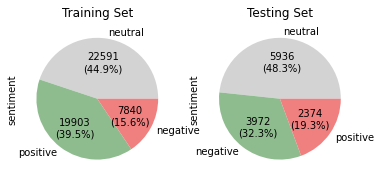

In [0]:
def show_autopct(pct, data):
  absolute = int(pct/100.*np.sum(data))
  return  "{:d}\n({:.1f}%)".format(absolute, pct)
  
plt.subplot(1, 2, 1)
task_a_train_df['sentiment'].value_counts().plot(
    kind='pie',
    autopct=lambda pct: show_autopct(pct, task_a_train_df['sentiment'].value_counts()),
    colors=['lightgray', 'darkseagreen', 'lightcoral']
);
plt.title('Training Set');


plt.subplot(1, 2, 2)
task_a_test_df['sentiment'].value_counts().plot(
    kind='pie',
    # figsize=(7,4),
    autopct=lambda pct: show_autopct(pct, task_a_test_df['sentiment'].value_counts()),
    colors=['lightgray', 'darkseagreen', 'lightcoral']
);
plt.title('Testing Set');




In [0]:
task_b_train_df[task_b_train_df['text'].str.contains('not')]

,id,topic,sentiment,text,ori_text
4,629226490152914944,@microsoft,positive,"Microsoft, I may not prefer your gaming branch...","Microsoft, I may not prefer your gaming branch..."
8,629797991826722816,@microsoft,negative,"After attempting a reinstall, it still bricks,...","After attempting a reinstall, it still bricks,..."
16,631543121407442946,@microsoft,negative,@Microsoft support for 365 has been terrible. ...,@Microsoft support for 365 has been terrible. ...
20,632536348419690496,@microsoft,negative,@eyesonfoxorg @Microsoft I'm still using Vista...,@eyesonfoxorg @Microsoft I'm still using Vista...
22,632810315227467776,@microsoft,negative,@MisterMetokur @Microsoft @ATT @NSAGov That's ...,@MisterMetokur @Microsoft @ATT @NSAGov That's ...
...,...,...,...,...,...
20377,521536294670065664,welbeck,positive,"""@asadaslamawan today was all about Ozil not b...","""@asadaslamawan today was all about Ozil not b..."
20433,522106648916393985,wwat,positive,"""GUYS there's a chance I might go back to the ...","""GUYS there's a chance I might go back to the ..."
20436,521315004289912832,wwat,positive,i may or may not be driving an hour and a half...,i may or may not be driving an hour and a half...
20474,520384978820296705,yougov,negative,"""@LouiseBaldock great work; you may or may not...","""@LouiseBaldock great work; you may or may not..."


In [0]:
positive = task_b_train_df[task_b_train_df['sentiment'] == 'positive']['topic'].value_counts(sort=False).to_frame(name='positive')
negative = task_b_train_df[task_b_train_df['sentiment'] == 'negative']['topic'].value_counts(sort=False).to_frame(name='negative')
neutral = task_b_train_df[task_b_train_df['sentiment'] == 'neutral']['topic'].value_counts(sort=False).to_frame(name='neutral')
# negative = task_b_train_df['topic'][task_b_train_df['sentiment'] == 'negative'].value_counts(sort=False)
# neutral = task_b_train_df['topic'][task_b_train_df['sentiment'] == 'neutral'].value_counts(sort=False)
joined = positive.join(negative).join(neutral)

joined = joined[(joined['positive'] > 0) & (joined['negative']>0)]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(joined)

                       positive  negative  neutral
frank gifford               151       5.0      NaN
bolton                        3       1.0      NaN
caitlyn jenner               24      69.0      NaN
james rodriguez              13       3.0      NaN
jan hooks                     3       2.0      NaN
the vamps                    55       5.0      NaN
justin bieber               117      27.0      NaN
ipod                         56       7.0      NaN
ventura                       8       2.0      NaN
david price                 114       9.0      NaN
t-mobile                     44      21.0      NaN
vampire diaries              15       1.0      NaN
moto g                       58       4.0      NaN
chris evans                  94      27.0      NaN
lady gaga                    71       5.0      NaN
janet jackson                95       3.0      NaN
kerry                        39      19.0      NaN
jessica                       9       2.0      NaN
tom brady                    77

<BarContainer object of 303 artists>

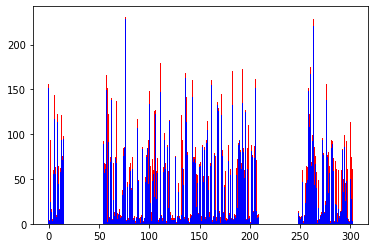

In [0]:

plt.bar(range(joined.shape[0]), joined['positive'], label='positive', color='blue')
plt.bar(range(joined.shape[0]), joined['negative'], label='negative', color='red', bottom=joined['positive'])

# Building Classifier

## Build Dataset


In [0]:
from torch.utils.data import DataLoader, Dataset
from torchtext.data import TabularDataset, Field, LabelField, BucketIterator
from sklearn.preprocessing import LabelEncoder
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.preprocessor import TextPreProcessor

In [0]:
# read csv file as torchtext's TabularDataset
def csv_to_tabular_dataset(filepath, fields):
  tabular_daset = TabularDataset(
      path=filepath,
      fields = fields,
      format='tsv',
      skip_header=True
  )
  return tabular_daset

## Neural Network

three layers:
1. embedding layer (transform one-hot encoding vector into a dense embedding vector)
2. RNN
3. linear layer (output)

In [0]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
               bidirectional, dropout, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    # self.rnn = nn.RNN(embedding_dim, hidden_dim)
    self.rnn = nn.LSTM(embedding_dim,
                       hidden_dim,
                       num_layers=n_layers,
                       bidirectional=bidirectional,
                       dropout=dropout,
                       )
    self.fully_connected = nn.Linear(hidden_dim*2, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, text, text_length):
    # text dimention is [sentence len, batch size]
    
    # embedded dimention is [sentence len, batch size, embedding_dim]
    embedded = self.dropout(self.embedding(text))

    # pack the sequence
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length)
    # print('packed_embedded:')
    # print(packed_embedded)
    packet_output, (hidden, cell) = self.rnn(packed_embedded)

    # unpack the sequence
    output, output_length = nn.utils.rnn.pad_packed_sequence(packet_output)

    # output dimention is [sentence len, batch size, hidden dim * num directions]
    # output over padding tokens are zero tensors

    # hidden dimension is [num layers*num directions, batch size, hidden dim]
    # cell dimension is also [num layers*num directions, batch size, hidden dim]

    #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
    #and apply dropout

    # hidden dimension is [batch size, hid dim*num directions]
    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
    
    return self.fully_connected(hidden)


In [0]:
def count_model_params(model):
  # number of parameters that are trainable
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Train the Model

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
def calculate_performance(y, preds):
  # get the index of the max probability 
  Y_pred = preds.argmax(dim = 1, keepdim = True).squeeze(1)
  Y_pred = Y_pred.detach().cpu().clone().numpy()
  
  Y_true = y.detach().cpu().clone().numpy()

  acc = accuracy_score(Y_true, Y_pred)
  rec = recall_score(Y_true, Y_pred, average='macro')
  prec= precision_score(Y_true, Y_pred, average='macro')
  f1  = f1_score(Y_true, Y_pred, average='macro')
  return acc, rec, prec, f1, Y_true, Y_pred



In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_rec = 0
    epoch_prec = 0
    epoch_f1 = 0

    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        text, text_length = batch.text
        predictions = model(text, text_length).squeeze(1)
        
        
        loss = criterion(predictions, batch.sentiment.long())
        
        acc, rec, prec, f1, Y_true, Y_pred = calculate_performance(batch.sentiment, predictions)
      
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_rec += rec.item()
        epoch_prec += prec.item()
        epoch_f1 += f1.item()

        avg_loss = epoch_loss / len(iterator)
        avg_acc = epoch_acc / len(iterator)
        avg_rec = epoch_rec / len(iterator)
        avg_prec = epoch_prec / len(iterator)
        avg_f1 = epoch_f1 / len(iterator)

    return avg_loss, avg_acc, avg_rec, avg_prec, avg_f1, Y_true, Y_pred

In [0]:
def evaluate(model, iterator, criterion):   
    epoch_loss = 0
    epoch_acc = 0
    epoch_rec = 0
    epoch_prec = 0
    epoch_f1 = 0
    
    Y_true = []
    Y_pred = []
    model.eval()

    with torch.no_grad():
    
        for batch in iterator:
            text, text_length = batch.text
            predictions = model(text, text_length).squeeze(1)
            actuals = batch.sentiment
 
            loss = criterion(predictions, batch.sentiment.long())
            
            acc, rec, prec, f1, y_true, y_pred = calculate_performance(batch.sentiment, predictions)
            
            Y_true = np.concatenate([Y_true,y_true])
            Y_pred = np.concatenate([Y_pred,y_pred])

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_rec += rec.item()
            epoch_prec += prec.item()
            epoch_f1 += f1.item()

            avg_loss = epoch_loss / len(iterator)
            avg_acc = epoch_acc / len(iterator)
            avg_rec = epoch_rec / len(iterator)
            avg_prec = epoch_prec / len(iterator)
            avg_f1 = epoch_f1 / len(iterator)
    return avg_loss, avg_acc, avg_rec, avg_prec, avg_f1, Y_true, Y_pred

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
import requests, zipfile, io
from pathlib import Path
from torchtext.vocab import Vectors
import torch.optim as optim
import dill

def build_torch_dataset(csv_filepath, fields, vocab_params, is_training_data=True):
	batch_size = vocab_params['batch_size']
	max_vocab_size = vocab_params['max_vocab_size']
	pretrained_embedding_filepath = vocab_params['pretrained_embedding']['filepath']
	pretrained_embedding_url = vocab_params['pretrained_embedding']['url']
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
	data = csv_to_tabular_dataset(
	  csv_filepath,
	  fields = fields,
	)
	if not is_training_data:
		# split into batches
		empty, empty, test_iterator = BucketIterator.splits(
				(None, None, data), 
				batch_sizes = (None, None, batch_size),
				sort_key=lambda x: len(x.text),
				sort_within_batch = True,
				device = device)
		return test_iterator
	else:		
		# split train data as traid:validation
		train_data, valid_data = data.split(split_ratio=0.8)

		# split into batches
		train_iterator, valid_iterator = BucketIterator.splits(
				(train_data, valid_data), 
				batch_sizes = (batch_size, batch_size),
				sort_key=lambda x: len(x.text),
				sort_within_batch = True,
				device = device)

		# build vocabulary
		# check if we need to download vector file
		if not Path(pretrained_embedding_filepath).is_file():
			# download vector file (in .zip)
			r = requests.get(pretrained_embedding_url)
			z = zipfile.ZipFile(io.BytesIO(r.content))
			# unzip the file
			z.extractall()

		ROW_NUM.build_vocab(train_data)
		SENTIMENT.build_vocab(train_data)
		TEXT.build_vocab(train_data,
										max_size = max_vocab_size,
										vectors = Vectors(pretrained_embedding_filepath),
										unk_init = torch.Tensor.normal_
										)

		return ROW_NUM, TEXT, SENTIMENT, train_iterator, valid_iterator


def tune_hyperparams(config, ROW_NUM, TEXT, SENTIMENT, train_iterator, valid_iterator, model_filepath, best_valid_loss):
	UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
	PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

	# build the RNN object
	model = RNN(
		len(TEXT.vocab),
		config['embedding_dim'],
		config['hidden_dim'],
		len(SENTIMENT.vocab),
		config['n_layers'],
		config['is_bidirectional'],
		config['dropout'],
		PAD_IDX,
	)

	# print the model and its number of params
	print(model.parameters)
	print(count_model_params(model))
	print(model)
	for p in model.parameters():
	  print(p.numel())

	# replace the initial weights of the embedding layer with the pretrained embeddings
	pretrained_embeddings = TEXT.vocab.vectors
	model.embedding.weight.data.copy_(pretrained_embeddings)

  # initialise UNK and PAD tokens to zeros
	model.embedding.weight.data[UNK_IDX] = torch.zeros(config['embedding_dim'])
	model.embedding.weight.data[PAD_IDX] = torch.zeros(config['embedding_dim'])

	optimiser = optim.Adam(model.parameters())
	criterion = nn.CrossEntropyLoss()

	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	model = model.to(device)
	criterion = criterion.to(device)

	# --- EARLY STOPPING
	use_early_stopping = True
	early_stopping_patience = 2

	for epoch in range(config['n_epochs']):
		start_time = time.time()

		train_loss, train_acc, train_rec, train_prec, train_f1, train_Y_true, train_Y_pred = train(model, train_iterator, optimiser, criterion)
		valid_loss, valid_acc, valid_rec, valid_prec, valid_f1, valid_Y_true, valid_Y_pred = evaluate(model, valid_iterator, criterion)

		end_time = time.time()

		epoch_mins, epoch_secs = epoch_time(start_time, end_time)

		if valid_loss < best_valid_loss:
			best_valid_loss = valid_loss
			# save the model as a file
			checkpoint = {
					'model' : model,
					'state_dict' : model.state_dict(),
					'optimiser' : optimiser.state_dict(),
			}
			torch.save(checkpoint, model_filepath)
	 		# save the Field(s)
			with open(cfg['paths']['fields']['row_num'], "wb")as f:
					dill.dump(ROW_NUM,f)
			with open(cfg['paths']['fields']['text'], "wb")as f:
					dill.dump(TEXT,f)
			with open(cfg['paths']['fields']['sentiment'], "wb")as f:
					dill.dump(SENTIMENT,f)
		else:
			early_stopping_patience -= 1   
		print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
		print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')
		print(f'\tTrain Acc : {train_acc*100:.2f}% | Val. Acc : {valid_acc*100:.2f}%')
		print(f'\tTrain Rec : {train_rec*100:.2f}% | Val. Rec : {valid_rec*100:.2f}%')
		print(f'\tTrain Prec: {train_prec*100:.2f}% | Val. Prec: {valid_prec*100:.2f}%')
		print(f'\tTrain F1  : {train_f1*100:.2f}% | Val. F1  : {valid_f1*100:.2f}%')

		# check if early stopping is needed
		if use_early_stopping:
			if early_stopping_patience < 0:
				print('Early stopping!' )
				break

	# after completing all epochs, visualise the word vectors
	vectors = model.embedding.weight.data
	labels = [l for l in TEXT.vocab.itos]
	
	print('best valid loss: ', best_valid_loss)
	return best_valid_loss

In [0]:
params = {
    'vocab': {
        'batch_size' : [32, 64],
	      'max_vocab_size' : [50000, 100000],
  	    'pretrained_embedding': [{
            'url' : 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip',
            'filepath': './crawl-300d-2M.vec',
            'embedding_dim': 300,
        },{
            'url' : 'http://nlp.stanford.edu/data/glove.twitter.27B.zip',
            'filepath': './glove.twitter.27B.200d.txt',
            'embedding_dim' : 200,
        },],
        'preprocessing' : [{
            'normalize' : ['url', 'email', 'percent', 'money', 'phone', 'user',
                'time', 'date', 'number'],
            'annotate' : ['hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored'],
            'spell_correct_elong' : True, #previously False
            'to_lowercase': True,    
        },
        ]
    },
    'nn': { 
          'hidden_dim': [128, 256],  #previously only 256
          'n_layers': [2, 3],
          'is_bidirectional': [True],
          'dropout': [0.5, 0.8],
          'n_epochs': [20],
    }
}

def generate_text_processor(preprocessing_params):
  text_processor = TextPreProcessor(
    # normalized these terms (ex: "google.com" into "<url>")
    normalize = preprocessing_params['normalize'],

    # annotate these terms (ex: "#win" into ["<hashtag>", "win", "</hashtag>"])
    annotate = preprocessing_params['annotate'],
    fix_html=True,
    segmenter = 'twitter',
    corrector='twitter',
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=preprocessing_params['spell_correct_elong'],
    tokenizer = SocialTokenizer(lowercase=preprocessing_params['to_lowercase']).tokenize,
    dicts = [emoticons]
  )
  return text_processor

def custom_tokenizer(example):
  return text_processor.pre_process_doc(example)

from itertools import product
def get_cartesian_product(d):
  # get all possible combination of a dictionary containing lists
  return [dict(zip(d, v)) for v in product(*d.values())]



# RUN EXPERIMENTS / MAIN
vocab_params_trials = get_cartesian_product(params['vocab'])
nn_params_trials = get_cartesian_product(params['nn'])
best_valid_loss = float('inf')

for vocab_params in vocab_params_trials:
  # build torch dataset and build the vocab.
  # this should be done only once during hyperparam searching
  print('-'*25  )
  print(vocab_params)

  # text_processor will be used inside the custom_tokenizer
  text_processor = generate_text_processor(vocab_params['preprocessing'])
  TEXT = Field(tokenize=custom_tokenizer,
              include_lengths=True)
  SENTIMENT = LabelField(dtype = torch.int)
  ROW_NUM = Field()
 

  fields = [('row_num', ROW_NUM), ('text', TEXT), ('sentiment', SENTIMENT)]
  ROW_NUM, TEXT, SENTIMENT, train_iterator, valid_iterator = build_torch_dataset(train_csv_filepath, fields, vocab_params, True)

  for nn_params in nn_params_trials:
    # execute the training process
      nn_params['embedding_dim'] = vocab_params['pretrained_embedding']['embedding_dim']
      print('#'*25)
      print(nn_params)
  
      best_valid_loss = tune_hyperparams(nn_params, ROW_NUM, TEXT, SENTIMENT, train_iterator, valid_iterator, saved_model_filepath, best_valid_loss)

-------------------------
{'batch_size': 32, 'max_vocab_size': 50000, 'pretrained_embedding': {'url': 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip', 'filepath': './crawl-300d-2M.vec', 'embedding_dim': 300}, 'preprocessing': {'normalize': ['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'date', 'number'], 'annotate': ['hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored'], 'spell_correct_elong': True, 'to_lowercase': True}}
Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


100%|█████████▉| 1999377/1999995 [03:25<00:00, 11685.96it/s]

#########################
{'hidden_dim': 128, 'n_layers': 2, 'is_bidirectional': True, 'dropout': 0.5, 'n_epochs': 20, 'embedding_dim': 300}
<bound method Module.parameters of RNN(
  (embedding): Embedding(35593, 300, padding_idx=1)
  (rnn): LSTM(300, 128, num_layers=2, dropout=0.5, bidirectional=True)
  (fully_connected): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)>
11514255
RNN(
  (embedding): Embedding(35593, 300, padding_idx=1)
  (rnn): LSTM(300, 128, num_layers=2, dropout=0.5, bidirectional=True)
  (fully_connected): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
10677900
153600
65536
512
512
153600
65536
512
512
131072
65536
512
512
131072
65536
512
512
768
3


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickl

Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 0.786 | Val. Loss: 0.727
	Train Acc : 63.30% | Val. Acc : 67.44%
	Train Rec : 57.77% | Val. Rec : 60.54%
	Train Prec: 59.75% | Val. Prec: 68.94%
	Train F1  : 56.20% | Val. F1  : 60.87%
Epoch: 02 | Epoch Time: 0m 16s
	Train Loss: 0.646 | Val. Loss: 0.675
	Train Acc : 71.67% | Val. Acc : 69.79%
	Train Rec : 68.43% | Val. Rec : 66.04%
	Train Prec: 69.85% | Val. Prec: 67.57%
	Train F1  : 67.50% | Val. F1  : 65.46%
Epoch: 03 | Epoch Time: 0m 16s
	Train Loss: 0.553 | Val. Loss: 0.703
	Train Acc : 76.39% | Val. Acc : 68.75%
	Train Rec : 74.43% | Val. Rec : 63.45%
	Train Prec: 75.57% | Val. Prec: 67.36%
	Train F1  : 73.42% | Val. F1  : 63.55%
Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 0.463 | Val. Loss: 0.800
	Train Acc : 80.91% | Val. Acc : 67.88%
	Train Rec : 79.18% | Val. Rec : 65.29%
	Train Prec: 80.06% | Val. Prec: 65.61%
	Train F1  : 78.41% | Val. F1  : 64.22%
Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 0.384 | Val. Loss: 0.846
	Train Acc : 84


100%|█████████▉| 1192050/1193514 [01:20<00:00, 14994.76it/s]

#########################
{'hidden_dim': 128, 'n_layers': 2, 'is_bidirectional': True, 'dropout': 0.5, 'n_epochs': 20, 'embedding_dim': 200}
<bound method Module.parameters of RNN(
  (embedding): Embedding(35593, 200, padding_idx=1)
  (rnn): LSTM(200, 128, num_layers=2, dropout=0.5, bidirectional=True)
  (fully_connected): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)>
7852555
RNN(
  (embedding): Embedding(35593, 200, padding_idx=1)
  (rnn): LSTM(200, 128, num_layers=2, dropout=0.5, bidirectional=True)
  (fully_connected): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
7118600
102400
65536
512
512
102400
65536
512
512
131072
65536
512
512
131072
65536
512
512
768
3



100%|█████████▉| 1192050/1193514 [01:32<00:00, 14994.76it/s]

Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 0.803 | Val. Loss: 0.704
	Train Acc : 62.18% | Val. Acc : 68.74%
	Train Rec : 55.92% | Val. Rec : 62.71%
	Train Prec: 58.57% | Val. Prec: 68.67%
	Train F1  : 54.62% | Val. F1  : 63.05%
Epoch: 02 | Epoch Time: 0m 16s
	Train Loss: 0.678 | Val. Loss: 0.682
	Train Acc : 69.66% | Val. Acc : 69.12%
	Train Rec : 65.94% | Val. Rec : 66.52%
	Train Prec: 68.07% | Val. Prec: 67.03%
	Train F1  : 65.11% | Val. F1  : 65.32%
Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.603 | Val. Loss: 0.685
	Train Acc : 73.78% | Val. Acc : 69.64%
	Train Rec : 71.17% | Val. Rec : 64.48%
	Train Prec: 72.59% | Val. Prec: 67.67%
	Train F1  : 70.26% | Val. F1  : 64.40%
Early stopping!
best valid loss:  0.6747388335447463
#########################
{'hidden_dim': 128, 'n_layers': 2, 'is_bidirectional': True, 'dropout': 0.8, 'n_epochs': 20, 'embedding_dim': 200}
<bound method Module.parameters of RNN(
  (embedding): Embedding(35593, 200, padding_idx=1)
  (rnn): LSTM(200, 128, num

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Test Loss: 0.759
Test Acc : 65.20%
Test Rec : 65.30%
Test Prec: 62.61%
Test F1  : 62.72%
3


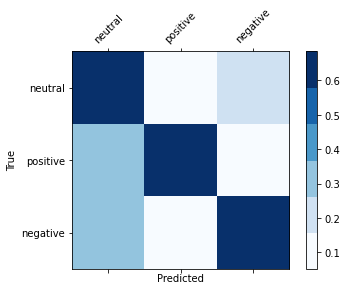

In [0]:
def load_checkpoint(cfg, filepath):
  # load the model and params
  checkpoint = torch.load(filepath)

  model = checkpoint['model']
  model.load_state_dict(checkpoint['state_dict'])

	# save the Field(s)
  with open(cfg['paths']['fields']['row_num'],"rb")as f:
      ROW_NUM = dill.load(f)
  with open(cfg['paths']['fields']['text'],"rb")as f:
      TEXT = dill.load(f)
  with open(cfg['paths']['fields']['sentiment'],"rb")as f:
      SENTIMENT = dill.load(f)
  fields = [('row_num', ROW_NUM), ('text', TEXT), ('sentiment', SENTIMENT)]

  for parameter in model.parameters():
    parameter.requires_grad = False
  return model, test_iterator, fields


import seaborn as sn

def generate_confusion_matrix(Y_true, Y_pred, labels, normalize=None):
  cm = confusion_matrix(Y_true, Y_pred, normalize=normalize)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm, cmap=plt.cm.get_cmap('Blues', 6))
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels, rotation=45)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()
  
def execute_testing_process(model_filepath, test_iterator):
  # load the best model architecture, params and weights gained from training process
  model, test_iterator, fields = load_checkpoint(cfg, model_filepath)
  criterion = nn.CrossEntropyLoss()

  test_loss, test_acc, test_rec, test_prec, test_f1, test_Y_true, test_Y_pred = evaluate(model, test_iterator, criterion)
  print(f'Test Loss: {test_loss:.3f}')
  print(f'Test Acc : {test_acc*100:.2f}%')
  print(f'Test Rec : {test_rec*100:.2f}%')
  print(f'Test Prec: {test_prec*100:.2f}%')
  print(f'Test F1  : {test_f1*100:.2f}%')

  num_classes = len(set(test_Y_true))
  print(num_classes)
  labels = []
  for i in range(num_classes):
    labels.append(SENTIMENT.vocab.itos[i])
    
  generate_confusion_matrix(test_Y_true, test_Y_pred, labels, normalize='true')

test_iterator = build_torch_dataset(test_csv_filepath, fields, vocab_params, is_training_data=False)
execute_testing_process(saved_model_filepath, test_iterator)